In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
file = r'''/Users/aaronhxzhang/AARD/Data/OneHotEncodingCrashData.xlsx'''
data = pd.ExcelFile(file)
crash_df = data.parse('Sheet1')
print(list(crash_df))
print(crash_df.shape)

['Crash Number', 'Crash Date', 'Crash Time', 'Crash Hour', 'City/Town', 'Locality', 'Crash Severity', 'Maximum Injury Severity Reported', 'Number of NonFatal Injuries', 'Number of Fatal Injuries', 'Number of Vehicles', 'Manner of Collision', 'Age of Driver - Youngest Known', 'Age of Driver - Oldest Known', 'Hit & Run', 'Road Surface', 'Ambient Light', 'Weather Condition', 'Traffic Way', 'Speed Limit', 'Roadway Intersection Type', 'Linked RI Number of Travel Lanes', 'Linked RI Street Operation', 'Linked RI Average Daily Traffic', 'Linked RI Year of ADT', 'X', 'Y', 'Road Segment ID', 'County']
(1063, 29)


In [3]:
crash_df = crash_df.drop(columns='Crash Time')
crash_df = crash_df.drop(columns='Crash Date')
crash_df = crash_df.drop(columns='Crash Number')
crash_df = crash_df.drop(columns='X')
crash_df = crash_df.drop(columns='Y')
crash_df = crash_df.drop(columns='County')
crash_df = crash_df.drop(columns='Locality')
crash_df = crash_df.drop(columns='Road Segment ID')
crash_df = crash_df.drop(columns='Linked RI Year of ADT')
crash_df = crash_df.drop(columns='Maximum Injury Severity Reported') #Later down in the code, it was revealed that this strongly correlated with nonfatal injuries (but these are basically the same thing)
crash_df = crash_df.drop(columns='Crash Severity') #This correlates strongest with nonfatal injuries (so need to remove) but for a different test (ex. relationship between crash type and severity), need to add this category back in

In [4]:
crash_df.sample(6)

,Crash Hour,City/Town,Number of NonFatal Injuries,Number of Fatal Injuries,Number of Vehicles,Manner of Collision,Age of Driver - Youngest Known,Age of Driver - Oldest Known,Hit & Run,Road Surface,Ambient Light,Weather Condition,Traffic Way,Speed Limit,Roadway Intersection Type,Linked RI Number of Travel Lanes,Linked RI Street Operation,Linked RI Average Daily Traffic
738,08:00AM to 08:59AM,ACTON,0,0,2,"Sideswipe, same direction",25-34,55-64,No hit and run,Dry,Daylight,Clear,Not reported,0,T-intersection,2,Two-way traffic,9978
192,05:00PM to 05:59PM,ACTON,1,0,2,Angle,25-34,25-34,No hit and run,Dry,Daylight,Clear,"Two-way, divided, unprotected median",35,T-intersection,2,Two-way traffic,12100
262,02:00PM to 02:59PM,ACTON,0,0,2,Angle,65-74,75-84,No hit and run,Dry,Daylight,Cloudy/Cloudy,"Two-way, not divided",40,T-intersection,2,Two-way traffic,16407
688,12:00PM to 12:59PM,ACTON,0,0,2,"Sideswipe, same direction",45-54,45-54,No hit and run,Dry,Daylight,Clear/Clear,"Two-way, not divided",40,Not at junction,2,Two-way traffic,17028
419,02:00PM to 02:59PM,ACTON,0,0,2,Rear-end,25-34,75-84,No hit and run,Dry,Daylight,Clear,"Two-way, not divided",0,T-intersection,2,Two-way traffic,16445
73,04:00PM to 04:59PM,ACTON,0,0,2,"Sideswipe, same direction",21-24,35-44,No hit and run,Dry,Daylight,Clear/Clear,"Two-way, divided, unprotected median",35,Not at junction,2,Two-way traffic,7700


In [11]:
crash_df['Speed Limit']=np.where(crash_df['Speed Limit'] == 0, 10, crash_df['Speed Limit'])
crash_df['Speed Limit'].unique()

array([30, 40, 25, 10, 35,  5, 45, 55, 20, 26])

In [14]:
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '1', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '2', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '3', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '4', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '0', 'none', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries'].unique()

array(['none', '1+'], dtype=object)

In [15]:
def summarize_data(df):
    for column in df.columns:
            print(column)
            if df.dtypes[column] == np.object:    #categorical data
                print(df[column].value_counts())
            else:
                print (df[column].describe())
                
            print ('\n')
            
summarize_data(crash_df)


Crash Hour
03:00PM to 03:59PM    98
04:00PM to 04:59PM    96
06:00PM to 06:59PM    96
05:00PM to 05:59PM    87
02:00PM to 02:59PM    72
08:00AM to 08:59AM    71
12:00PM to 12:59PM    71
11:00AM to 11:59AM    68
01:00PM to 01:59PM    63
09:00AM to 09:59AM    53
07:00AM to 07:59AM    52
10:00AM to 10:59AM    49
07:00PM to 07:59PM    48
06:00AM to 06:59AM    35
09:00PM to 09:59PM    23
11:00PM to 11:59PM    17
08:00PM to 08:59PM    15
10:00PM to 10:59PM    14
05:00AM to 05:59AM    12
01:00AM to 01:59AM     5
12:00AM to 12:59AM     5
03:00AM to 03:59AM     5
04:00AM to 04:59AM     4
02:00AM to 02:59AM     4
Name: Crash Hour, dtype: int64


City/Town
ACTON    1063
Name: City/Town, dtype: int64


Number of NonFatal Injuries
none    821
1+      242
Name: Number of NonFatal Injuries, dtype: int64


Number of Fatal Injuries
count    1063.000000
mean        0.003763
std         0.061256
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name:

# Encode the Categorical Features as Numbers

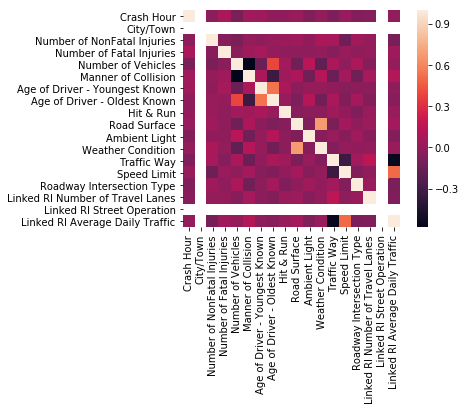

,Crash Hour,City/Town,Number of NonFatal Injuries,Number of Fatal Injuries,Number of Vehicles,Manner of Collision,Age of Driver - Youngest Known,Age of Driver - Oldest Known,Hit & Run,Road Surface,Ambient Light,Weather Condition,Traffic Way,Speed Limit,Roadway Intersection Type,Linked RI Number of Travel Lanes,Linked RI Street Operation,Linked RI Average Daily Traffic
1053,18,0,1,1,1,7,5,5,0,0,4,0,3,45,6,2,0,34428
1054,1,0,0,0,1,7,1,1,0,7,4,15,2,55,3,2,0,34428
1055,7,0,1,0,2,0,1,4,0,7,1,15,2,55,3,2,0,34428
1056,23,0,0,0,2,3,2,4,0,0,4,0,3,10,3,2,0,16653
1057,23,0,1,0,1,7,1,1,0,7,4,15,2,55,3,2,0,34428
1058,11,0,1,0,1,0,4,4,0,0,0,1,4,30,3,2,0,16445
1059,7,0,1,0,2,5,4,5,0,0,5,1,4,35,3,2,0,16445
1060,11,0,1,0,2,3,3,5,0,0,1,0,1,10,6,2,0,16445
1061,3,0,1,0,3,3,0,2,0,7,2,18,4,30,8,2,0,3129
1062,3,0,1,0,2,6,1,2,0,7,4,16,2,10,3,2,0,34428


In [16]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

#Calculate the correlation and plot it
encoded_data, _ = number_encode_features(crash_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.tail(10)

In [17]:
#Strong correlation between oldest driver and manner of collision shown by heatmap
crash_df[["Age of Driver - Oldest Known", "Manner of Collision"]].head(10)

,Age of Driver - Oldest Known,Manner of Collision
0,16-20,Single vehicle crash
1,45-54,Angle
2,45-54,Single vehicle crash
3,25-34,Single vehicle crash
4,25-34,Unknown
5,65-74,"Sideswipe, same direction"
6,65-74,Rear-end
7,35-44,Angle
8,25-34,Single vehicle crash
9,25-34,Single vehicle crash


In [18]:
#Explore strong correlation between weather condition and road surface
crash_df[["Weather Condition", "Road Surface"]].head(10)

,Weather Condition,Road Surface
0,Clear/Clear,Wet
1,Rain/Cloudy,Wet
2,Not Reported,Dry
3,Snow/Snow,Snow
4,Clear,Dry
5,Clear/Clear,Dry
6,Clear,Dry
7,Snow,Snow
8,Snow/Cloudy,Snow
9,Snow/Cloudy,Snow


In [19]:
#Looks kind of like the same data, however weather condition looks like it would produce more predictive data since it has more specific categories
#We will delete this later if we need to

In [20]:
encoded_data, encoders = number_encode_features(crash_df)
new_series = encoded_data["Number of NonFatal Injuries"]

In [21]:
#Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("Number of NonFatal Injuries")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


# Begin Logistic Regression

In [22]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
y_pred = cls.predict(X_test)

In [24]:
print(accuracy_score(y_test, y_pred))

0.7554858934169278


In [25]:
#Mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [26]:
print(fit_and_evaluate(cls))

0.2445141065830721


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
# Try random forest method
random_forest = RandomForestRegressor(random_state=60)
print(fit_and_evaluate(random_forest))

0.3674279743245261


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Index(['Crash Hour', 'City/Town', 'Number of Fatal Injuries',
       'Number of Vehicles', 'Manner of Collision',
       'Age of Driver - Youngest Known', 'Age of Driver - Oldest Known',
       'Hit & Run', 'Road Surface', 'Ambient Light', 'Weather Condition',
       'Traffic Way', 'Speed Limit', 'Roadway Intersection Type',
       'Linked RI Number of Travel Lanes', 'Linked RI Street Operation',
       'Linked RI Average Daily Traffic'],
      dtype='object')


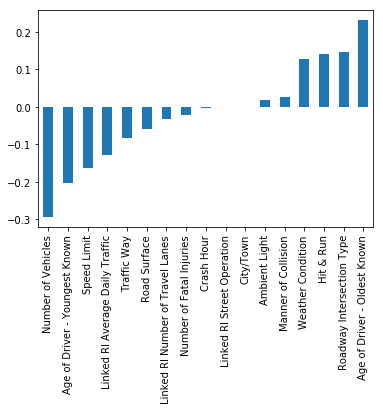

Age of Driver - Oldest Known        0.232667
Roadway Intersection Type           0.145778
Hit & Run                           0.141332
Weather Condition                   0.128885
Manner of Collision                 0.025554
Ambient Light                       0.017286
City/Town                           0.000000
Linked RI Street Operation          0.000000
Crash Hour                         -0.003523
Number of Fatal Injuries           -0.022412
Linked RI Number of Travel Lanes   -0.031890
Road Surface                       -0.059440
Traffic Way                        -0.083550
Linked RI Average Daily Traffic    -0.129096
Speed Limit                        -0.163138
Age of Driver - Youngest Known     -0.202100
Number of Vehicles                 -0.294768
dtype: float64


In [28]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print(X_train.columns)
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print(coefs.sort_values(ascending = False))

# Try one hot encoding

In [29]:
# Copy the original data
features = crash_df.copy()

# Select the numeric columns
numeric_subset = crash_df.select_dtypes('number')
categorical_subset = crash_df.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("Number of NonFatal Injuries")])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print(features.head())

   Number of Fatal Injuries  Number of Vehicles  Speed Limit  \
0                         0                   1           30   
1                         0                   2           40   
2                         0                   1           25   
3                         0                   1           25   
4                         0                   1           30   

   Linked RI Number of Travel Lanes  Linked RI Average Daily Traffic  \
0                                 2                             3101   
1                                 2                            15082   
2                                 2                              700   
3                                 2                             7700   
4                                 2                             7700   

   Crash Hour_01:00AM to 01:59AM  Crash Hour_01:00PM to 01:59PM  \
0                              0                              0   
1                              0                

In [30]:
# Replace the inf with nan
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
features = features.dropna()

# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [31]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7178683385579937


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
print(fit_and_evaluate(cls))

0.28213166144200624


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print(coefs.sort_values(ascending = False))  #most important factors that contributed to crashes involving injuries

Weather Condition_Snow/Sleet, hail (freezing rain or drizzle)    0.608579
Weather Condition_Snow/Blowing sand, snow                        0.426966
Weather Condition_Rain/Rain                                      0.389450
Road Surface_Ice                                                 0.372725
Road Surface_Not reported                                        0.364168
Age of Driver - Youngest Known_16-20                             0.362428
Manner of Collision_Unknown                                      0.323161
Road Surface_Slush                                               0.311222
Crash Hour_03:00PM to 03:59PM                                    0.264323
Number of Fatal Injuries                                         0.202494
Weather Condition_Cloudy/Clear                                   0.196155
Age of Driver - Oldest Known_75-84                               0.189435
Age of Driver - Youngest Known_65-74                             0.179251
Age of Driver - Oldest Known_55-64    

# Trying to get more info by grouping

In [34]:
crash_df['Speed Limit'].unique()

array([30, 40, 25, 10, 35,  5, 45, 55, 20, 26])

In [ ]:
#Further group numerical groups into categorical groups to gain more insight
#Speed limit
speedLimit_group = []
for limit in crash_df["Speed Limit"]:
    if limit < 20:
        age_group.append("<25")
    elif 25 <= age <= 34:
        age_group.append("25-34")
    elif 34 < age <= 44:
        age_group.append("35-44")
    elif 44 < age <= 54:
        age_group.append("45-54")
    elif 54 < age <= 65:
        age_group.append("55-64")
    else:
        age_group.append("65 and over")

NameError: name 'income_df' is not defined